### Crude Oil

## 7:3

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [178]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../dataset/Crude Oil WTI.csv')
df_sorted = df.sort_index(ascending=False)
df1=df_sorted.reset_index()['Price']

In [179]:
df_sorted

,Date,Price,Open,High,Low,Vol.,Change %
1385,3/1/2019,55.80,57.22,57.88,55.57,684.19K,-2.48%
1384,3/4/2019,56.59,55.83,57.00,55.81,549.40K,1.42%
1383,3/5/2019,56.56,56.45,57.19,56.09,538.40K,-0.05%
1382,3/6/2019,56.22,56.28,56.40,55.42,637.68K,-0.60%
1381,3/7/2019,56.66,56.20,56.99,56.08,628.82K,0.78%
...,...,...,...,...,...,...,...
4,5/27/2024,78.65,77.84,78.80,77.75,NaN,1.20%
3,5/28/2024,79.83,77.81,80.29,77.69,334.07K,1.50%
2,5/29/2024,79.23,80.26,80.62,78.99,259.59K,-0.75%
1,5/30/2024,77.91,79.28,79.42,77.63,373.78K,-1.67%


In [180]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [181]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [182]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [183]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [184]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [185]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [186]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2218
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0187
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0043
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0031
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0023
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0023
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.2392e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.7518e-04
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/s

In [187]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [188]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [189]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 78.5947539580168


In [190]:
# Lấy 100 phần tử cuối cùng từ test_data làm đầu vào ban đầu
x_input = test_data[-100:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

# Dự đoán cho 30 ngày tiếp theo
lst_output_30 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_30.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_60 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_60.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_90 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_90.extend(yhat.tolist())
    i += 1


In [191]:
# Tạo index cho 30 ngày, 60 ngày và 90 ngày dự đoán
predict_index_30 = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + 30, step=1)
predict_index_60 = pd.RangeIndex(start=len(train_data) + len(test_data) + 30, stop=len(train_data) + len(test_data) + 60, step=1)
predict_index_90 = pd.RangeIndex(start=len(train_data) + len(test_data) + 60, stop=len(train_data) + len(test_data) + 90, step=1)

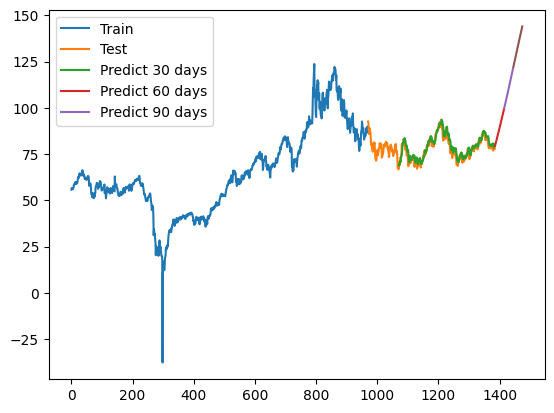

In [192]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
predict_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(predict_data_index,(y_pred))
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_30))
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_60))
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90))
plt.legend(['Train', 'Test', 'Predict 30 days', 'Predict 60 days', 'Predict 90 days'])
plt.show()

### Gasoline RBOB

## 7:3

In [193]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('../dataset/Gasoline RBOB.csv')
df_sorted = df.sort_index(ascending=False)
df1=df_sorted.reset_index()['Price']

In [194]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [195]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [196]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [197]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [198]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [199]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [200]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0568
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0108
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0060
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0039
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0024
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0024
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0025
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0022
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0023
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - lo

In [201]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [202]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [203]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 2.0036179236404794


In [204]:
# Lấy 100 phần tử cuối cùng từ test_data làm đầu vào ban đầu
x_input = test_data[-100:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

# Dự đoán cho 30 ngày tiếp theo
lst_output_30 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_30.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_60 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_60.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_90 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_90.extend(yhat.tolist())
    i += 1


In [205]:
# Tạo index cho 30 ngày, 60 ngày và 90 ngày dự đoán
predict_index_30 = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + 30, step=1)
predict_index_60 = pd.RangeIndex(start=len(train_data) + len(test_data) + 30, stop=len(train_data) + len(test_data) + 60, step=1)
predict_index_90 = pd.RangeIndex(start=len(train_data) + len(test_data) + 60, stop=len(train_data) + len(test_data) + 90, step=1)

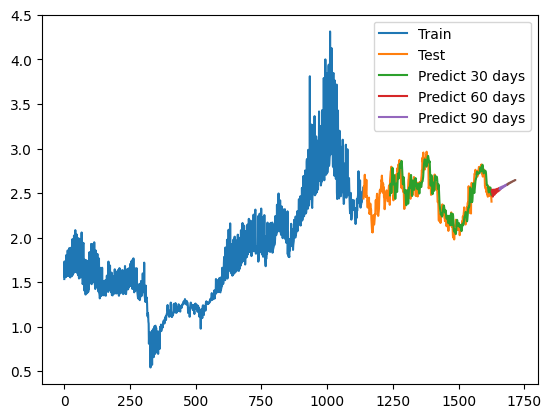

In [206]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
predict_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(predict_data_index,(y_pred))
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_30))
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_60))
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90))
plt.legend(['Train', 'Test', 'Predict 30 days', 'Predict 60 days', 'Predict 90 days'])
plt.show()

### Heating Oil

## 7:3

In [207]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('../dataset/Heating Oil.csv')
df_sorted = df.sort_index(ascending=False)
df1=df_sorted.reset_index()['Price']

In [208]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [209]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [210]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [211]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [212]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [213]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [214]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0345
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0062
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0022
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0011
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.3582e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.8931e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.9799e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.1619e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.0689e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.9634e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.9854e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 5.4260e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.9011e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.8957e-04
Epoch 15/100
14/1

In [215]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [216]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [217]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 2.2847670526780504


In [218]:
# Lấy 100 phần tử cuối cùng từ test_data làm đầu vào ban đầu
x_input = test_data[-100:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

# Dự đoán cho 30 ngày tiếp theo
lst_output_30 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_30.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_60 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_60.extend(yhat.tolist())
    i += 1

# Dự đoán cho 30 ngày tiếp theo
lst_output_90 = []
i = 0
while i < 30:
    x_input = np.array(temp_input[-n_steps:])
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst_output_90.extend(yhat.tolist())
    i += 1


In [219]:
# Tạo index cho 30 ngày, 60 ngày và 90 ngày dự đoán
predict_index_30 = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + 30, step=1)
predict_index_60 = pd.RangeIndex(start=len(train_data) + len(test_data) + 30, stop=len(train_data) + len(test_data) + 60, step=1)
predict_index_90 = pd.RangeIndex(start=len(train_data) + len(test_data) + 60, stop=len(train_data) + len(test_data) + 90, step=1)

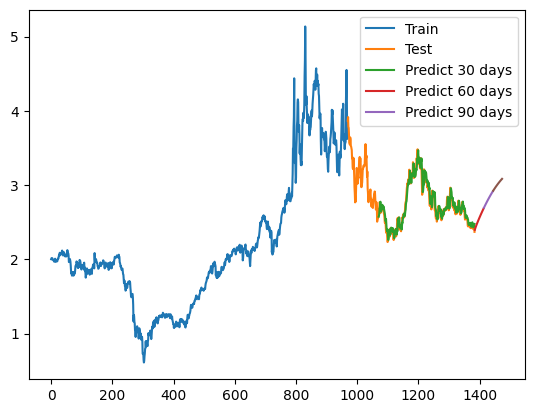

In [220]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
predict_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(predict_data_index,(y_pred))
prediect_data_30days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_30))
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_60))
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90))
plt.legend(['Train', 'Test', 'Predict 30 days', 'Predict 60 days', 'Predict 90 days'])
plt.savefig('ten_file.png')
plt.show()